In [1]:
import pyemma as pm
import deeptime as dt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import *
from pathlib import Path
from deeptime.numeric import is_sorted, spd_inv_sqrt, schatten_norm
import scipy
from msmtools.estimation import transition_matrix


In [2]:
def bs(dtrajs): 
    rng = np.random.default_rng(49587)
    ix = rng.choice(np.arange(len(dtrajs)), size=len(dtrajs), replace=True)
    return [dtrajs[i] for i in ix]
    

In [15]:
dtrajs_24 = [np.load(x) for x in Path('hp_24').glob('1FME*.npy')]
dtrajs_235 = [np.load(x) for x in Path('hp_235').glob('1FME*.npy')]

# dtrajs_24 = bs(dtrajs_24_raw)
# dtrajs_235 = bs(dtrajs_235_raw)

lag = 41

Compare scores/timescales etc. 

In [16]:
est_24 = dt.markov.msm.MaximumLikelihoodMSM(reversible=True, lagtime=lag)
est_24.fit(dtrajs_24)
mod_24 = est_24.fetch_model()
mod_24.score(dim=2), mod_24.timescales(1)[0], (mod_24.eigenvalues()[:2]**2).sum()

(1.9759410174262293, 3346.15811579258, 1.975792111413774)

In [17]:
mod_24.timescales()[:3]

array([3346.15811579, 2120.46762739, 1601.7284516 ])

In [18]:
hp_samples = pd.read_hdf('../experiments/hpsample.h5')


In [43]:
hp_samples.loc[[24, 235]]

,cluster__max_iter,cluster__stride,tica__dim,tica__lag,tica__kinetic_map,tica__stride,cluster__k,feature__value,dihedrals__which,distances__scheme,distances__transform,distances__steepness,distances__centre
hp_ix,,,,,,,,,,,,,
24,1000,10,20,60,True,1,471,distances,NaN,ca,logistic,6.081760,0.224891
235,1000,10,19,90,True,1,499,distances,NaN,ca,logistic,21.897952,0.859444


In [20]:
est_235 = dt.markov.msm.MaximumLikelihoodMSM(reversible=True, lagtime=lag)
est_235.fit(dtrajs_235)
mod_235 = est_235.fetch_model()
mod_235.score(dim=2), mod_235.timescales()[0], (mod_235.eigenvalues()[:2]**2).sum()

(1.972337380583308, 2865.456871641474, 1.9717888525193787)

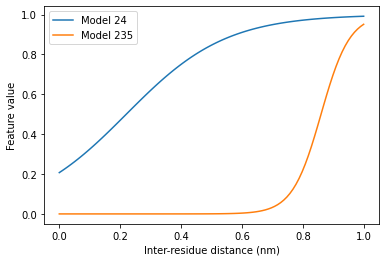

In [53]:
x = np.linspace(0, 1, 100)
y1 = 1/(1+np.exp(-6.1*(x-0.22)))
y2 = 1/(1+np.exp(-21.2*(x-0.86)))
plt.plot(x, y1, label='Model 24')
plt.plot(x, y2, label='Model 235')
plt.legend()
plt.ylabel('Feature value')
plt.xlabel('Inter-residue distance (nm)')
plt.savefig('24_vs_235_featurization.png')

In [ ]:
x

Check evs

In [15]:
def vamp(dtrajs: List[np.ndarray], lag: int, dim: int = 2, epsilon: float = 1e-15) -> float: 
    
    # Get the covariance koopman model
    est = dt.markov.msm.MaximumLikelihoodMSM(reversible=True, lagtime=lag)
    est.fit(dtrajs)
    mod = est.fetch_model()
    
    cmat = mod.count_model.count_matrix
    tmat = mod.transition_matrix
    
    # Empirical covariances
    cov0t = cmat
    cov00 = np.diag(cov0t.sum(axis=1))
    covtt = np.diag(cov0t.sum(axis=0))
    
    # Symmetrized tmat
    
    # reweight operator to empirical distribution
    C0t_re = cov00 @ tmat
    # symmetrized operator and SVD
    # By construction - this will not give rise to SVD where singular values == eigenvalues of tmat. 
    tmat_sym = np.linalg.multi_dot([spd_inv_sqrt(cov00, epsilon=epsilon, method='schur'), C0t_re,
                                 spd_inv_sqrt(covtt, epsilon=epsilon, method='schur')])
    
        
    print('norm(K.T - K) = ', schatten_norm(tmat_sym.T - tmat_sym, 2) ** 2)
    
    # SVD
    U, singular_values, Vt = scipy.linalg.svd(tmat_sym, compute_uv=True)
    U = spd_inv_sqrt(cov00, epsilon=epsilon) @ U
    Vt = Vt @ spd_inv_sqrt(covtt, epsilon=epsilon)
    V = Vt.T
    
    
    # Sort by singular values
    sort_ix = np.argsort(singular_values)[::-1][:dim]  # indices to sort in descending order
    U = U[:, sort_ix]
    V = V[:, sort_ix]
    singular_values = singular_values[sort_ix]
    
    
    
    
    A = np.atleast_2d(spd_inv_sqrt(U.T.dot(cov00).dot(U), epsilon=epsilon))
    B = np.atleast_2d(U.T.dot(cov0t).dot(V))
    C = np.atleast_2d(spd_inv_sqrt(V.T.dot(covtt).dot(V), epsilon=epsilon))
    ABC = np.linalg.multi_dot([A, B, C])
    vamp1 = schatten_norm(ABC, 1) ** 1
    vamp2 = schatten_norm(ABC, 2) ** 2
    
    with np.printoptions(precision=10):
        print('A: ')
        print(np.round(A, 10))
        print('B: ')
        print(np.round(B, 10))
        print('C: ')
        print(np.round(C, 10))
        print('Lambdas     =', mod.eigenvalues(2))
        print('Singulars   =', singular_values[:2])
        print('Lambdas^2   =', mod.eigenvalues(2)**2)
        print('Singulars^2 =', singular_values[:2]**2)
        
        print('Sum lambdas =   ', np.round(mod.eigenvalues(2).sum(), 4))
        print('VAMP1 =         ', np.round(vamp1, 4))
        print('Sum lambdas^2 = ', np.round((mod.eigenvalues(2)**2).sum(), 4))
        print('VAMP2 =         ', np.round(vamp2, 4))              
        print(f't_2 =            {np.round(mod.timescales(1)[0], 0)}')
    print('-'*80)

vamp(dtrajs_24, lag=41)
vamp(dtrajs_235, lag=41)

norm(K.T - K) =  1.3756021025852028e-26
A: 
[[ 1. -0.]
 [-0.  1.]]
B: 
[[ 321276.0000000866 -131235.7950314326]
 [-131460.746906928    62353.2443806402]]
C: 
[[1. 0.]
 [0. 1.]]
Lambdas     = [1.           0.9982888291]
Singulars   = [1.           0.9982888291]
Lambdas^2   = [1.           0.9965805863]
Singulars^2 = [1.           0.9965805863]
Sum lambdas =    1.9983
VAMP1 =          383629.3103
Sum lambdas^2 =  1.9966
VAMP2 =          141610957135.707
t_2 =            23940.0
--------------------------------------------------------------------------------
norm(K.T - K) =  3.190677648872517e-25
A: 
[[ 1. -0.]
 [-0.  1.]]
B: 
[[320140.0000000092 -51800.1045062353]
 [-52628.2835300336 140124.4383569972]]
C: 
[[ 1. -0.]
 [-0.  1.]]
Lambdas     = [1.           0.9842636129]
Singulars   = [1.           0.9842636129]
Lambdas^2   = [1.           0.9687748597]
Singulars^2 = [1.           0.9687748597]
Sum lambdas =    1.9843
VAMP1 =          460265.1835
Sum lambdas^2 =  1.9688
VAMP2 =          